In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Уменьшение размерности 

## Проклятие размерности (curse of dimentionality)

Часто датасеты состоят из очень большого количества признаков - тысячи.  
Это затрудняет поиск моделей.  
Можно сильно уменьшить размерность без больших потерь информации, то есть сократить объем входных данных, упростить расчет модели.

Пространство вариантов растет экспоненциально:

Рассмотрим отрезок длины 10  

$$10^1 = 10$$
$$10^2 = 100$$
$$10^3 = 1000$$
...

Экспоненциальный рост

![](https://images.slideplayer.com/12/3353293/slides/slide_5.jpg)

Рассмотрим единичный гиперкуб.

В двумерном пространстве это просто квадрат $1\times1$

Какова вероятность того, что точка попадет в отступ 0.001 от границы?

<img src="pictures/curse.png" width=500>

In [ ]:
# площадь синего квадрата
1 * 1

# площадь фиолетового квадрата
(1 - 0.001 * 2) * (1 - 0.001 * 2)

In [3]:
1 * 1 - (1 - 0.001 * 2) * (1 - 0.001 * 2)

0.0039959999999999996

In [4]:
def point_prob(n_dimensions, length, margin):
    return length ** n_dimensions - (length - margin * 2) ** (n_dimensions)

In [5]:
point_prob(2, 1, 0.001)

0.0039959999999999996

In [6]:
point_prob(3, 1, 0.001)

0.005988007999999989

In [7]:
point_prob(10, 1, 0.001)

0.019820956648050614

In [8]:
point_prob(10000, 1, 0.001)

0.999999997979714

Среднее расстояние между точками гиперкуба:

In [9]:
from scipy.spatial import distance

def avg_dist(n_dimensions):
    dist = 0.
    n_points = 100000
    for i in range(n_points):
        p1 = np.random.rand(n_dimensions)
        p2 = np.random.rand(n_dimensions)
        dist += distance.euclidean(p1, p2)
    return dist / n_points

In [10]:
avg_dist(1)

0.3337184165564064

In [ ]:
# this is tooo sloooow
# avg_dist(1)
# 0.3332980439577846

In [ ]:
# avg_dist(2)
# 0.5218287867554282

In [ ]:
# avg_dist(3)
# 0.6621043139420382

In [ ]:
# avg_dist(10)
# 1.2674922241953468

In [ ]:
# avg_dist(100)
# 4.076181952866157

In [ ]:
# avg_dist(1000)
# 12.906989192432318

In [ ]:
# avg_dist(10000)
# 40.82415131097075

Новая точка будет далеко от других, что означает, что построенная модель скорее всего не учитывает новые данные, то есть модель недообучена или переобучена

# PCA - Principal Component Analysis (метод главных компонент)

Хорошая статья с объяснением внутренностей: https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

Очень красивая визуализация: http://setosa.io/ev/principal-component-analysis/

**Основная цель:** найти подпространства меньшей размерности, в ортогональной проекции на которые разброс данных (a.k.a дисперсия, то есть среднеквадратичное отклонение от среднего значения) максимален

* Позволяет уменьшить число переменных, выбрав самые изменчивые из них
* Новые переменные являются линейной комбинацией старых переменных

![](https://miro.medium.com/max/602/1*H38t3YUv_QktLwalzDYRRg.png)

Будем выбирать такую ось, в которой сохраняется максимальное количество дисперсии. 

Так мы потеряем как можно меньше информации при проецировании.   

Следующая ось ортогональна первой, выбирается из всех других осей как ось с наибольшей оставшейся дисперсией.

Вектор, описывающий такую ось называется главной компонентой (principal component)

**Алгоритм:**

1. Стандартизируем данные (если не в одном масштабе)
2. Считаем матрицу корреляций или ковариаций по нашим данным
3. Получаем собственные вектора и собственные значения по матрице корреляций/ковариаций (или используем SVD)
4. Сортируем собственные значения по убыванию (чем выше собственное значение - тем выше дисперсия, которую объясняет соответствующая компонента). 
5. По вкусу - выбираем $k$ собственных значений, где $k < d$ (изначальной размерности данных), чтобы сократить размерность
6. Берем соответствующие собственные вектора (отсортированные в том же порядке, что и собственные числа) и составляем из них матрицу проекции $W$
7. Умножаем исходные данные $X$ на $W$ и получаем матрицу главных компонент.

## Поехали

In [3]:
from sklearn.decomposition import PCA

In [4]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

scaler = StandardScaler()

X_iris_scaled = scaler.fit_transform(X_iris)

pca = PCA()
pca.fit(X_iris_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [5]:
type(X_iris_scaled)

numpy.ndarray

In [6]:
X_iris.shape

(150, 4)

### Очень важная штука - объяснённая дисперсия

In [7]:
np.cumsum(pca.explained_variance_ratio_)

array([0.72962445, 0.95813207, 0.99482129, 1.        ])

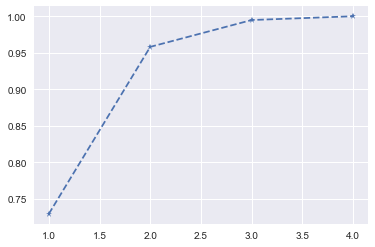

In [8]:
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_), '*--');

In [9]:
x_new = PCA(n_components=2).fit_transform(X_iris_scaled)
x_new.shape

(150, 2)

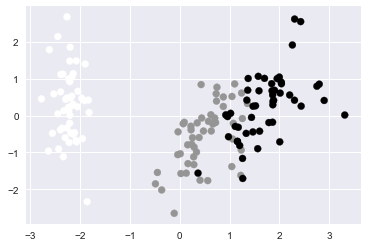

In [10]:
plt.scatter(x_new[:, 0], x_new[:, 1], c=y_iris);

### Данные посложнее

In [11]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [12]:
X.shape, y.shape

((70000, 784), (70000,))

In [13]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

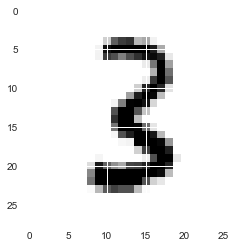

In [14]:
plt.imshow(X[50000].reshape(28, 28), cmap=plt.cm.gray_r);

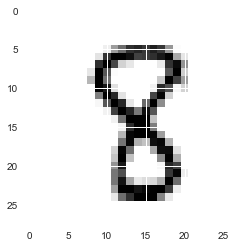

In [15]:
plt.imshow(X[50001].reshape(28, 28), cmap=plt.cm.gray_r);

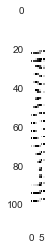

In [16]:
plt.imshow(X[50001].reshape(112, 7), cmap=plt.cm.gray_r);

In [17]:
pca = PCA()
pca.fit(scaler.fit_transform(X))
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

332

In [18]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

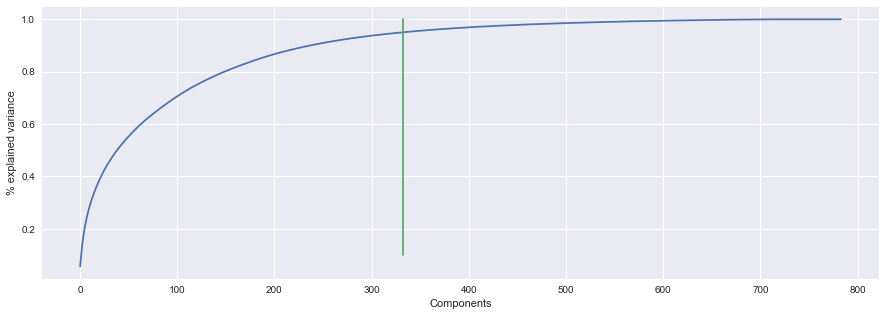

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(cumsum)
plt.plot([d, d], [0.1, 1])
plt.xlabel("Components")
plt.ylabel("% explained variance")
plt.show()

* PCA понижает размерность признакового пространства
* Новые компоненты являются линейной комбинацией исходных признаков
* Новые компоненты - ортогональны
* Можно применять в моделях и для визуализации
* Работает не всегда :(

# Применение для визуализации

In [25]:
# from sklearn.datasets import fetch_mldata
# X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [20]:
idx = np.random.randint(X.shape[0], size=10000)
X_sample = X[idx,:]
y_sample = y[idx]

X_sample.shape, X.shape, y_sample.shape, y.shape

((10000, 784), (70000, 784), (10000,), (70000,))

In [21]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_sample)

In [22]:
X_reduced.shape

(10000, 2)

AttributeError: module 'seaborn' has no attribute 'scatterplot'

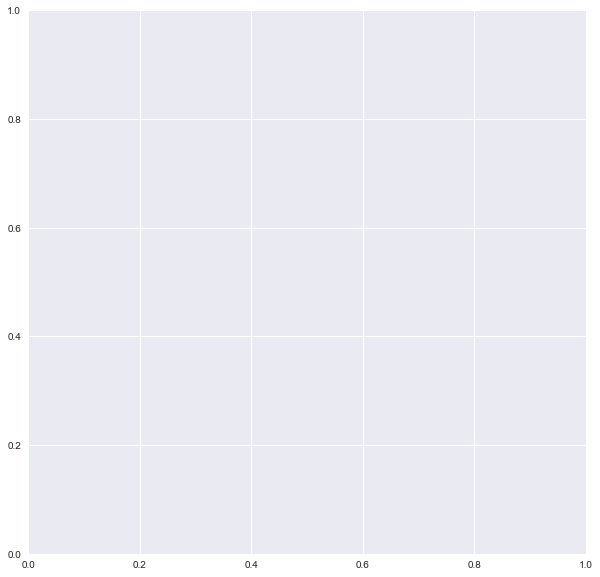

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=X_reduced[:, 0], 
    y=X_reduced[:, 1], 
    hue=y_sample.astype(int), 
    palette="CMRmap",
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by PCA", fontsize=18)
plt.show()

In [54]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# TSNE

## t-Distributed Stochastic Neighbour Embedding

- https://github.com/DmitryUlyanov/Multicore-TSNE
- https://github.com/CannyLab/tsne-cuda

#### How to use TSNE effectively: https://distill.pub/2016/misread-tsne/

# Гиперпараметры очень важны

![](pictures/1.png)

![](pictures/2.png)

# Размер кластера не имеет смысла

![](pictures/3.png)

# Расстояния между кластерами (возможно) не имеют значения

![](pictures/4.png)

![](pictures/5.png)

# Случайный шум может показаться не случайным

![](pictures/6.png)

![](pictures/7.png)

In [31]:
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X_sample)

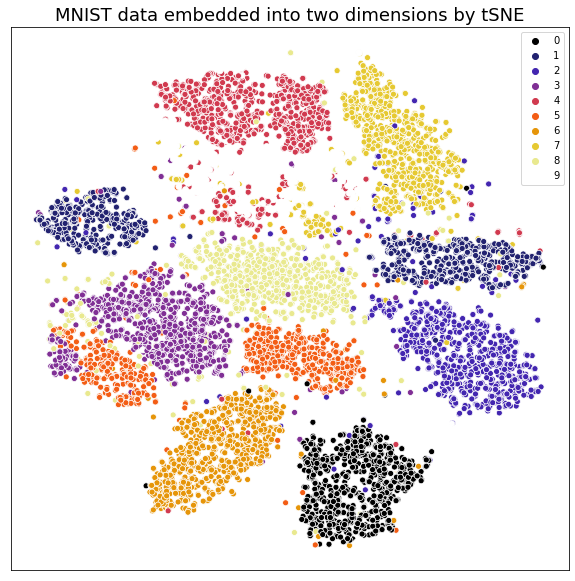

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
    hue=y_sample.astype(int), 
    palette="CMRmap",
    legend='full'
)
plt.title("MNIST data embedded into two dimensions by tSNE", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

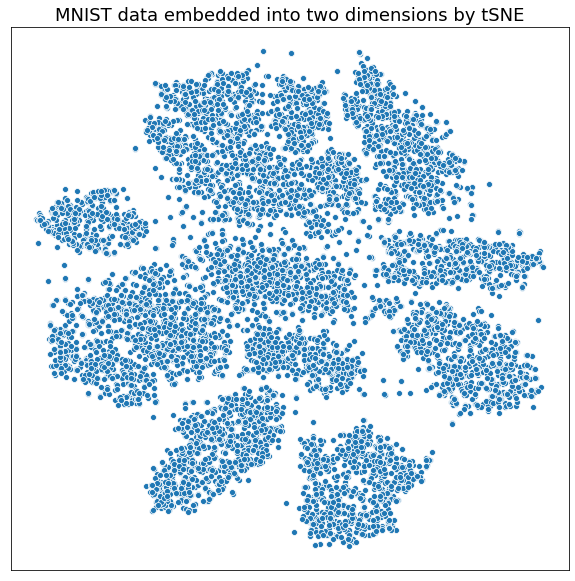

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
    #hue=y_sample.astype(int), 
    #palette="CMRmap",
    #legend='full'
)
plt.title("MNIST data embedded into two dimensions by tSNE", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

http://lvdmaaten.github.io/tsne

# UMAP

Как tSNE, только круче (но не всегда)

https://pair-code.github.io/understanding-umap/

In [34]:
import umap

In [36]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_sample)

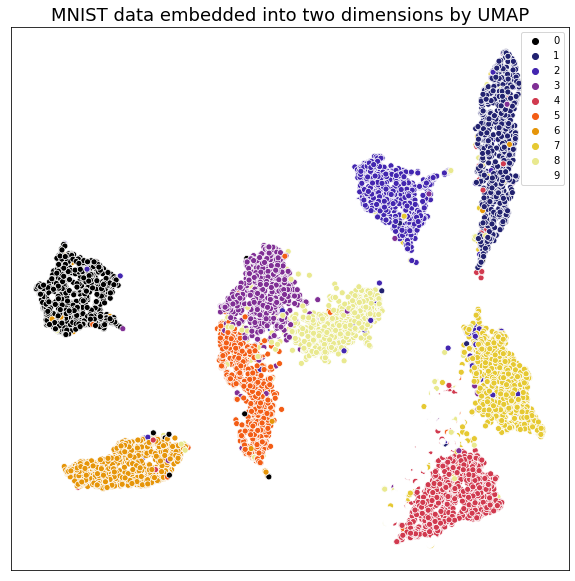

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=y_sample.astype(int), 
    palette="CMRmap", 
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

# Для моделей

https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)



In [63]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12,nan
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09,nan
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09,nan
3,84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17,nan
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08,nan


In [64]:
df.shape

(569, 33)

In [65]:
df['diagnosis'] = pd.Categorical(df.diagnosis).codes 
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,...,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,842517,1,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,...,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,1,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,...,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,1,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,...,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,84358402,1,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,...,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [66]:
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [67]:
X = df.drop(['id', 'diagnosis'], axis=1)
X.shape
y = df['diagnosis']
y.shape

(569,)

In [68]:
scaler = StandardScaler()

In [69]:
X_scaled = scaler.fit_transform(X)

In [70]:
from MulticoreTSNE import MulticoreTSNE as TSNE

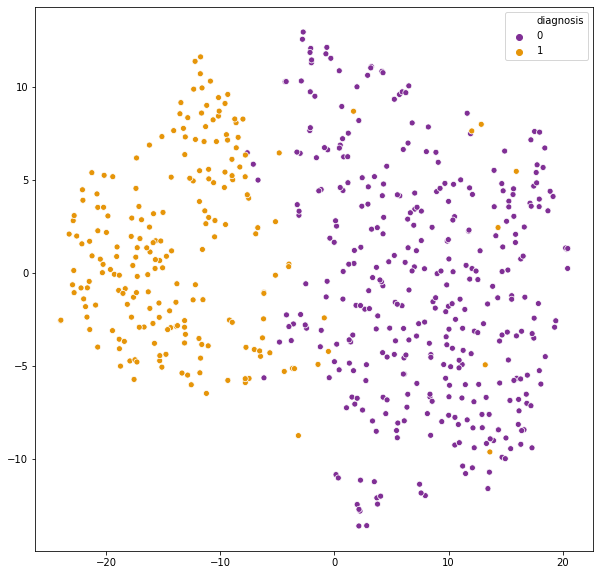

In [71]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
    hue=y.astype(int), 
    palette="CMRmap",
    legend='full'
);

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [74]:
lr = LogisticRegressionCV(cv=5)

In [75]:
lr.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [76]:
y_pred = lr.predict_proba(x_test)[:, 1]

In [77]:
roc_auc_score(y_test, y_pred)

0.9980893592004703

In [80]:
def analyzePCA(X, pca, explained_threshold=0.95):
    """Plot cumulative explaned variance of PCA"""
    pca.fit(X)
    pca_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(15,7))
    plt.plot(np.cumsum(pca_variance))
    plt.hlines(explained_threshold, 0, len(pca_variance))
    plt.title("Number of components to explain {}% of variance: {}".format(
        100*explained_threshold, np.argwhere(np.cumsum(pca_variance)>explained_threshold)[0]
    ))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

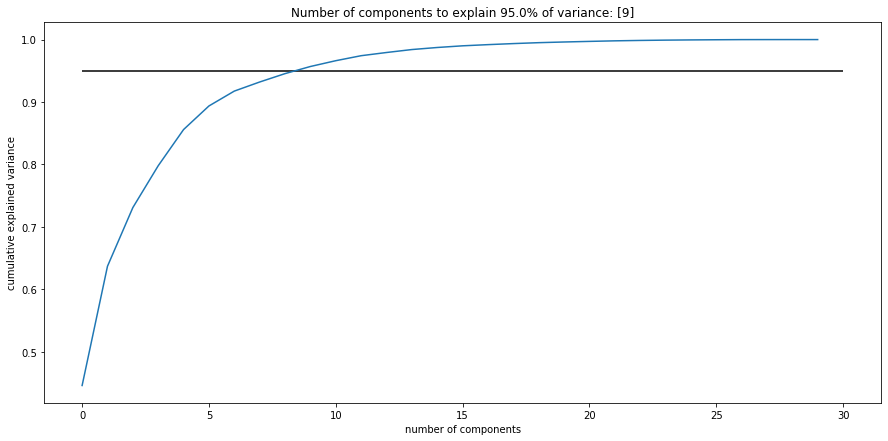

In [92]:
pca = PCA()
analyzePCA(x_train, pca, explained_threshold=0.95)

In [93]:
pca = PCA(n_components=9, random_state=42)
x_train_pca = pca.fit_transform(x_train)

In [94]:
x_train_pca.shape

(398, 9)

In [95]:
lr = LogisticRegressionCV(cv=5)
lr.fit(x_train_pca, y_train)
y_pred = lr.predict(pca.transform(x_test))
roc_auc_score(y_test, y_pred)

0.9761904761904762

# Дополнительные материалы
* https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
* https://www.kaggle.com/nirajvermafcb/principal-component-analysis-explained
* https://plot.ly/ipython-notebooks/principal-component-analysis/
* https://coolstatsblog.com/2015/03/21/principal-component-analysis-explained/
* http://blog.districtdatalabs.com/principal-component-analysis-with-python